In [47]:
#import packages
import scipy.linalg as scilin
import numpy as np
import json
import pandas as pd
import os
import matplotlib.pyplot as plt

In [48]:
#Functions Section

def EigenPrint_TwoMat(A,B):
    C = np.matmul(np.linalg.inv(B),A)
    eigen_vals,eigen_vects = scilin.eig(C)
    id_list = eigen_vals.argsort()[::-1]
    eigen_vals = eigen_vals[id_list]
    eigen_vects = eigen_vects[:,id_list]
    for i in range(len(eigen_vals)):
        print(f'Eigen Value: {eigen_vals[i]}')
    for j in range(len(eigen_vects)):
        print(f'Eigenvector: {eigen_vects[j]}')

def directory_check(directory_name):
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
        print(f"Directory '{directory_name}' created.")
    else:
        print(f"Directory '{directory_name}' already exists.")

In [49]:
#Read in the data from the JSON file
filename_load = "6917_new.json"
base_name = os.path.basename(filename_load).split('.')[0]
directory_check(base_name)
Output_File_Long = base_name +'/'+base_name +"_Eigen_Long.txt"
Output_File_Lat = base_name +'/'+base_name +"_Eigen_Lat.txt"
Output_File_Long_mat = base_name +'/'+base_name +'_Matrices_Long.txt'
Output_File_Lat_mat = base_name +'/'+base_name +'_Matrices_Lat.txt'
J_string = open(filename_load).read()
J_vals = json.loads(J_string)

#################  Aircraft Properties  ##################################

#Get the moment information of aircraft
I_xx = J_vals['aircraft']['Ixx[slug-ft^2]']
I_yy = J_vals['aircraft']['Iyy[slug-ft^2]']
I_zz = J_vals['aircraft']['Izz[slug-ft^2]']
I_xy = J_vals['aircraft']['Ixy[slug-ft^2]']
I_xz = J_vals['aircraft']['Ixz[slug-ft^2]']

#Name
#Plane_name = J_vals['aircraft']['name']

#Wing Information
Wing_Area = J_vals['aircraft']['wing_area[ft^2]']
Wing_Span = J_vals['aircraft']['wing_span[ft]']
Wing_MeanChord = Wing_Area/Wing_Span

#aircraft weight
Weight = J_vals['aircraft']['weight[lbf]']

#Launch Energy
#Launch_Energy = J_vals['aircraft']['launch_kinetic_energy[ft-lbf]']

#################  Air Properties  ########################################

#density
Air_Density = J_vals['analysis']['density[slugs/ft^3]']

#################  Aerodynamic Properties  #################################

#CL values
CL_0 = J_vals['aerodynamics']['CL']['0']
CL_alpha = J_vals['aerodynamics']['CL']['alpha']
CL_qbar = J_vals['aerodynamics']['CL']['qbar']
CL_alpha_hat = J_vals['aerodynamics']['CL']['alpha_hat']

#CY values
CY_beta = J_vals['aerodynamics']['CS']['beta']
CY_pbar = J_vals['aerodynamics']['CS']['pbar']
CY_rbar = J_vals['aerodynamics']['CS']['rbar']

#CD values
CD_L0 = J_vals['aerodynamics']['CD']['L0']
CD_L1 = J_vals['aerodynamics']['CD']['L']
CD_L2 = J_vals['aerodynamics']['CD']['L2']
CD_0 = CD_L0 + CD_L1*CL_0+CD_L2*CL_0**2
CD_alpha = CD_L1*CL_alpha + 2*CD_L2*CL_0*CL_alpha
CD_qbar = J_vals['aerodynamics']['CD']['qbar']

#Cl Values
Cl_beta = J_vals['aerodynamics']['Cl']['beta']
Cl_pbar = J_vals['aerodynamics']['Cl']['pbar']
Cl_rbar = J_vals['aerodynamics']['Cl']['rbar']

#Cm Values
Cm_0 = J_vals['aerodynamics']['Cm']['0']
Cm_alpha = J_vals['aerodynamics']['Cm']['alpha']
Cm_qbar = J_vals['aerodynamics']['Cm']['qbar']
Cm_alpha_hat = J_vals['aerodynamics']['Cm']['alpha_hat']

#Cn values
Cn_beta = J_vals['aerodynamics']['Cn']['beta']
Cn_pbar = J_vals['aerodynamics']['Cn']['pbar']
Cn_rbar = J_vals['aerodynamics']['Cn']['rbar']

#################  Solved Variables ############################################

#Gravity at location
g = 32.17 #gravity at logan elevation used for design

#Solve for the inital velocity given the launch conditions
#V_0 = np.sqrt(2*Launch_Energy*g/Weight) #Need to check if this is correct, don't do this, but we can do this later

#Get V_0 from the CL
V_0 = np.sqrt((Weight)/(0.5*Wing_Area*Air_Density*CL_0))
V_0 = J_vals['initial']['airspeed[ft/s]']
#CW of aircraft
CW = Weight/(0.5*Wing_Area*Air_Density*V_0**2)

print(f'Velocity: {V_0}')


Directory '6917_new' already exists.
Velocity: 15.8574


In [50]:
#Solving for all the Base Components found in eqs. 10.70-10.76 to then put into the matrices in 10.77 and 10.78, all variable must be unitless

#10.70 -10.72 not required because we don't know these variables and this is a glider

#10.73
R_gx = (g*Wing_MeanChord)/(2*V_0**2) 
R_gy = (g*Wing_Span)/(2*V_0**2) 
#10.74
R_rhox = (4*Weight/g)/(Air_Density*Wing_Area*Wing_MeanChord)
R_rhoy = (4*Weight/g)/(Air_Density*Wing_Area*Wing_Span)
#10.75 
R_xx = (8*I_xx)/(Air_Density*Wing_Area*Wing_Span**3)
R_yy = (8*I_yy)/(Air_Density*Wing_Area*Wing_MeanChord**3)
R_zz = (8*I_zz)/(Air_Density*Wing_Area*Wing_Span**3)
R_xz = (8*I_xz)/(Air_Density*Wing_Area*Wing_Span**3)
#10.76
#Not required since there is no thrust given this aircraft is a glider

In [51]:
#Generating the Matrices, going for the nondimensional form, Longitudinal Equations  
#10.77 B mat is the LHS matrix, A mat is the RHS matrix
A_mat_long = np.zeros([6,6])
B_mat_long = np.identity(6)

#Variables that could be changed, but assumed to be zero
CD_mu = 0
CL_mu_hat = 0
Cm_mu_hat = 0
CD_alpha_hat = 0
alpha_deg = 0
alpha_rad = alpha_deg*np.pi/180
#Fill in the A Matrix given what is known
    #Single Row
A_mat_long[0,0] = -2*CD_0 #+ CT_V*np.cos(alpha_rad)
A_mat_long[0,1] = CL_0-CD_alpha
A_mat_long[0,2] = -CD_qbar
A_mat_long[0,5] = -R_rhox*R_gx*np.cos(alpha_rad)
    #Second Row
A_mat_long[1,0] = -2*CL_0 #+ CT_V*np.sin(alpha_rad)
A_mat_long[1,1] = -CL_alpha-CD_0  #Variable is not correct currently, CD_0 is not correct
A_mat_long[1,2] = -CL_qbar+R_rhox
A_mat_long[1,5] = -R_rhox*R_gx*np.sin(alpha_rad)
    #Third Row
A_mat_long[2,0] = 2*Cm_0
A_mat_long[2,1] = Cm_alpha
A_mat_long[2,2] = Cm_qbar
    #Fourth Row
A_mat_long[3,0] = np.cos(alpha_rad)
A_mat_long[3,1] = np.sin(alpha_rad)
A_mat_long[3,5] = -np.sin(alpha_rad)
    #Fifth Row
A_mat_long[4,0] = -np.sin(alpha_rad)
A_mat_long[4,1] = np.cos(alpha_rad)
A_mat_long[4,5] = -np.cos(alpha_rad)
    #Sixth Row
A_mat_long[5,2] = 1

#Fill in the B Matrix given what is known
B_mat_long[0,0] = R_rhox+CD_mu
B_mat_long[0,1] = CD_alpha_hat
B_mat_long[1,0] = CL_mu_hat
B_mat_long[1,1] = R_rhox+CL_alpha_hat
B_mat_long[2,0] = -Cm_mu_hat
B_mat_long[2,1] = -Cm_alpha_hat
B_mat_long[2,2] = R_yy

#Create a New matrix using the A and B matrix to do the Eigen value solve

C_mat_long = np.matmul(np.linalg.inv(B_mat_long),A_mat_long)

#Generating the Matrices, going for the nondimensional form, Lateral Equations  
#10.77 B mat is the LHS matrix, A mat is the RHS matrix
A_mat_lat = np.zeros([6,6])
B_mat_lat = np.identity(6)

#Variables that could be changed, but assumed to be zero
CD_mu = 0
CL_mu_hat = 0
Cm_mu_hat = 0
CD_alpha_hat = 0
alpha_deg = 0
alpha_rad = alpha_deg*np.pi/180
#Fill in the A Matrix given what is known
    #Single Row
A_mat_lat[0,0] = CY_beta
A_mat_lat[0,1] = CY_pbar
A_mat_lat[0,2] = (CY_rbar-R_rhoy)
A_mat_lat[0,4] = R_rhoy*R_gy*np.cos(alpha_rad)
    #Second Row
A_mat_lat[1,0] = Cl_beta 
A_mat_lat[1,1] = Cl_pbar  
A_mat_lat[1,2] = Cl_rbar
    #Third Row
A_mat_lat[2,0] = Cn_beta
A_mat_lat[2,1] = Cn_pbar
A_mat_lat[2,2] = Cn_rbar
    #Fourth Row
A_mat_lat[3,0] = 1
A_mat_lat[3,5] = np.cos(alpha_rad)
    #Fifth Row
A_mat_lat[4,1] = 1
A_mat_lat[4,2] = np.tan(alpha_rad)
    #Sixth Row
A_mat_lat[5,2] = 1/np.cos(alpha_rad)

#Fill in the B Matrix given what is known
B_mat_lat[0,0] = R_rhoy
B_mat_lat[1,1] = R_xx
B_mat_lat[1,2] = -R_xz
B_mat_lat[2,1] = -R_xz
B_mat_lat[2,2] = R_zz

#Create a New matrix using the A and B matrix to do the Eigen value solve

C_mat_lat = np.matmul(np.linalg.inv(B_mat_lat),A_mat_lat)

#pd.DataFrame(C_mat_lat).head(6)



In [52]:
#Getting the actual Eigenvalues and Eigenvectors

eigen_vals_long,eigen_vects_long = scilin.eig(C_mat_long)


# Print eigenvalues and eigenvectors
print("Eigenvalues:")
for i, val in enumerate(eigen_vals_long):
    print(f"Eigenvalue {i + 1}: {val.real:.4f} + {val.imag:.4f}j")

print("\nEigenvectors:")
for i in range(2,len(eigen_vects_long)):
    print(f"Eigenvector {i + 1}:")
    for j in range(len(eigen_vects_long)):
        print(f"   {eigen_vects_long[j, i].real:.4f} + {eigen_vects_long[j, i].imag:.4f}j")

        #Getting the actual Eigenvalues and Eigenvectors

eigen_vals_lat,eigen_vects_lat = scilin.eig(C_mat_lat)


# Print eigenvalues and eigenvectors
print("Eigenvalues:")
for i, val in enumerate(eigen_vals_lat):
    print(f"Eigenvalue {i + 1}: {val.real:.4f} + {val.imag:.4f}j")

print("\nEigenvectors:")
for i in range(2,len(eigen_vects_lat)):
    print(f"Eigenvector {i + 1}:")
    for j in range(len(eigen_vects_lat)):
        print(f"   {eigen_vects_lat[j, i].real:.4f} + {eigen_vects_lat[j, i].imag:.4f}j")



Eigenvalues:
Eigenvalue 1: 0.0000 + 0.0000j
Eigenvalue 2: 0.0000 + 0.0000j
Eigenvalue 3: -0.3610 + 0.0000j
Eigenvalue 4: -0.1177 + 0.0000j
Eigenvalue 5: -0.0021 + 0.0286j
Eigenvalue 6: -0.0021 + -0.0286j

Eigenvectors:
Eigenvector 3:
   0.0427 + 0.0000j
   -0.3176 + 0.0000j
   -0.0078 + 0.0000j
   -0.1183 + 0.0000j
   0.9396 + 0.0000j
   0.0216 + 0.0000j
Eigenvector 4:
   -0.0365 + 0.0000j
   0.0404 + 0.0000j
   0.0084 + 0.0000j
   0.3098 + 0.0000j
   -0.9466 + 0.0000j
   -0.0710 + 0.0000j
Eigenvector 5:
   -0.0016 + 0.0217j
   0.0004 + -0.0051j
   0.0002 + 0.0006j
   0.7571 + 0.0000j
   0.1041 + 0.6442j
   0.0191 + -0.0067j
Eigenvector 6:
   -0.0016 + -0.0217j
   0.0004 + 0.0051j
   0.0002 + -0.0006j
   0.7571 + -0.0000j
   0.1041 + -0.6442j
   0.0191 + 0.0067j
Eigenvalues:
Eigenvalue 1: 0.0000 + 0.0000j
Eigenvalue 2: 0.0000 + 0.0000j
Eigenvalue 3: -34.4951 + 0.0000j
Eigenvalue 4: -0.5425 + 0.4811j
Eigenvalue 5: -0.5425 + -0.4811j
Eigenvalue 6: -0.5470 + 0.0000j

Eigenvectors:
Eigenve

In [53]:
#Get the amplitude and phase of each component as a numpy array from the eigenvectors

#long amp and phase matrices
amplitude_long = np.zeros_like(eigen_vects_long)
phase_long = np.zeros_like(eigen_vects_long)
#loop through columns
for j in range(eigen_vects_long.shape[0]):
     #loop through rows
     for i in range(eigen_vects_long.shape[1]):
          amplitude_long[i,j] = np.sqrt(eigen_vects_long[i,j].real**2 + eigen_vects_long[i,j].imag**2)
          phase_long[i,j] = np.arctan2(eigen_vects_long[i,j].imag,eigen_vects_long[i,j].real)*(180/np.pi)

#Lateral amp and phase matrices
amplitude_lat = np.zeros_like(eigen_vects_lat)
phase_lat = np.zeros_like(eigen_vects_lat)
#loop through columns
for j in range(eigen_vects_lat.shape[0]):
     #loop through rows
     for i in range(eigen_vects_lat.shape[1]):
          amplitude_lat[i,j] = np.sqrt(eigen_vects_lat[i,j].real**2 + eigen_vects_lat[i,j].imag**2)
          phase_lat[i,j] = np.arctan2(eigen_vects_lat[i,j].imag,eigen_vects_lat[i,j].real)*(180/np.pi)



In [54]:
#Going through the damping rate

variable_symbols_lat = ['Δβ', 'Δp_bar', 'Δr_bar', 'Δξ_y', 'ΔΦ', 'Δφ']
variable_symbols_long = ['Δμ', 'Δα', 'Δq_bar', 'Δξ_x', 'Δξ_z', 'ΔΘ']


for z in range(len(eigen_vals_long)):
    i = eigen_vals_long[z]
    print(f'-------------------------------------------------------------------------------') 
    print(f'Dimensionless Eigen Value: {i.real:8.6f}+{i.imag:12.8f}j')
    sigma = -i.real
    #Rigid Body mode
    if i.real == 0:
        print('\t Rigid Body Mode: Eigen Value: 0 ')
        print('\t No analysis required currently\n')
    #Convergent Modes Sigma > 0
    if sigma > 0:
        #Damping rate
        Damp_rate = sigma*2*V_0/Wing_MeanChord
        #99 Damping Time
        Damp_time_99 = np.log(0.01)/-Damp_rate
        #Damped natural frequency and Period
        if i.imag != 0:
            W_d = abs(i.imag)*2*V_0/Wing_MeanChord
            Period = (2*np.pi)/W_d
            #Damping Ratio
            Damp_Ratio =   -i.real/(np.sqrt(i.real**2 + i.imag**2)) 
        
        print(f'\t Damping Rate [1/s]: {Damp_rate:12.6f}')
        print(f'\t 99% Damping Time [s]: {Damp_time_99:12.6f}')
        if i.imag != 0:
            print(f'\t Damped Nat Freq: {W_d:12.6f}')
            print(f'\t Period: {Period:12.6f}')
            print(f'\t Damping Ratio: {Damp_Ratio:12.6f}')
        print('')
    #Divergent Modes Sigma < 0 
    if sigma < 0:
    #Damping rate
        Damp_rate = sigma*2*V_0/Wing_MeanChord
        #99 Damping Time
        Double_time = np.log(2.00)/-Damp_rate
        #Damped natural frequency and Period
        if i.imag != 0:
            W_d = abs(i.imag)*2*V_0/Wing_MeanChord
            Period = (2*np.pi)/W_d  
            #Damping Ratio
            Damp_Ratio =   -i.real/(np.sqrt(i.real**2 + i.imag**2)) 

        print(f'\t Damping Rate [1/s]: {Damp_rate:12.6f}')
        print(f'\t Doubling Time [s]: {Double_time:12.6f}')
        if i.imag != 0:
            print(f'\t Damped Nat Freq: {W_d:12.6f}')
            print(f'\t Period: {Period:12.6f}')
            print(f'\t Damping Ratio: {Damp_Ratio:12.6f}')
        print('')  

    #Print the Eigen Vector
    print(f'-------------------------------------------------------------------------------') 
    print(f'{"Variable":<15} {"Real Part":<15} {"Imaginary Part":<20} {"Amplitude":<15} {"Phase":<15}')
    eigen_vects_long = np.asarray(eigen_vects_long)
    for j in range(6):
        real = eigen_vects_long[j,z].real
        imag = eigen_vects_long[j,z].imag
        amp = amplitude_long[j,z].real
        phase_deg = phase_long[j,z].real
        symbol = variable_symbols_long[j]
        print(f'{symbol:<15} {real:<15.6f} {imag:<20.6f} {amp:<15.6f} {phase_deg:<15.6f}')
    print(f'-------------------------------------------------------------------------------') 



-------------------------------------------------------------------------------
Dimensionless Eigen Value: 0.000000+  0.00000000j
	 Rigid Body Mode: Eigen Value: 0 
	 No analysis required currently

-------------------------------------------------------------------------------
Variable        Real Part       Imaginary Part       Amplitude       Phase          
Δμ              0.000000        0.000000             0.000000        0.000000       
Δα              0.000000        0.000000             0.000000        0.000000       
Δq_bar          0.000000        0.000000             0.000000        0.000000       
Δξ_x            1.000000        0.000000             1.000000        0.000000       
Δξ_z            0.000000        0.000000             0.000000        0.000000       
ΔΘ              0.000000        0.000000             0.000000        0.000000       
-------------------------------------------------------------------------------
----------------------------------------------

In [55]:
#Going through the damping rate for lateral mode

for z in range(len(eigen_vals_lat)):
    i = eigen_vals_lat[z]
    print(f'-------------------------------------------------------------------------------') 
    print(f'Dimensionless Eigen Value: {i.real:8.6f}+{i.imag:12.8f}j')
    sigma = -i.real
    #Rigid Body mode
    if i.real == 0:
        print('\t Rigid Body Mode: Eigen Value: 0 ')
        print('\t No analysis required currently\n')
    #Convergent Modes Sigma > 0
    if sigma > 0:
        #Damping rate
        Damp_rate = sigma*2*V_0/Wing_Span
        #99 Damping Time
        Damp_time_99 = np.log(0.01)/-Damp_rate
        #Damped natural frequency and Period
        if i.imag != 0:
            W_d = abs(i.imag)*2*V_0/Wing_Span
            Period = (2*np.pi)/W_d
            #Damping Ratio
            Damp_Ratio =   -i.real/(np.sqrt(i.real**2 + i.imag**2))
        
        print(f'\t Damping Rate [1/s]: {Damp_rate:12.6f}')
        print(f'\t 99% Damping Time [s]: {Damp_time_99:12.6f}')
        if i.imag != 0:
            print(f'\t Damped Nat Freq: {W_d:12.6f}')
            print(f'\t Period: {Period:12.6f}')
            print(f'\t Damping Ratio: {Damp_Ratio:12.6f}')
        print('')
    #Divergent Modes Sigma < 0 
    if sigma < 0:
    #Damping rate
        Damp_rate = sigma*2*V_0/Wing_Span
        #99 Damping Time
        Double_time = np.log(2.00)/-Damp_rate
        #Damped natural frequency and Period
        if i.imag != 0:
            W_d = abs(i.imag)*2*V_0/Wing_Span
            Period = (2*np.pi)/W_d 
            #Damping Ratio
            Damp_Ratio =   -i.real/(np.sqrt(i.real**2 + i.imag**2))    

        print(f'\t Damping Rate [1/s]: {Damp_rate:12.6f}')
        print(f'\t Doubling Time [s]: {Double_time:12.6f}')
        if i.imag != 0:
            print(f'\t Damped Nat Freq: {W_d:12.6f}')
            print(f'\t Period: {Period:12.6f}')
            print(f'\t Damping Ratio: {Damp_Ratio:12.6f}')
        print('')  

    #Print the Eigen Vector
    print(f'-------------------------------------------------------------------------------') 
    print(f'{"Variable":<15} {"Real Part":<15} {"Imaginary Part":<20} {"Amplitude":<15} {"Phase":<15}')
    eigen_vects_lat = np.asarray(eigen_vects_lat)
    for j in range(6):
        real = eigen_vects_lat[j,z].real
        imag = eigen_vects_lat[j,z].imag
        amp = amplitude_lat[j,z].real
        phase_deg = phase_lat[j,z].real
        symbol = variable_symbols_lat[j]
        print(f'{symbol:<15} {real:<15.6f} {imag:<20.6f} {amp:<15.6f} {phase_deg:<15.6f}')
    print(f'-------------------------------------------------------------------------------') 

            

-------------------------------------------------------------------------------
Dimensionless Eigen Value: 0.000000+  0.00000000j
	 Rigid Body Mode: Eigen Value: 0 
	 No analysis required currently

-------------------------------------------------------------------------------
Variable        Real Part       Imaginary Part       Amplitude       Phase          
Δβ              0.000000        0.000000             0.000000        0.000000       
Δp_bar          0.000000        0.000000             0.000000        0.000000       
Δr_bar          0.000000        0.000000             0.000000        0.000000       
Δξ_y            1.000000        0.000000             1.000000        0.000000       
ΔΦ              0.000000        0.000000             0.000000        0.000000       
Δφ              0.000000        0.000000             0.000000        0.000000       
-------------------------------------------------------------------------------
----------------------------------------------

In [56]:
#Longitude write file to txt to use

def write_info_file_long(output_file, eigen_vals, eigen_vects, amplitude, phase, V_0, Wing_MeanChord):
    # Define the variable symbols list manually
    variable_symbols_long = ['Δμ', 'Δα', 'Δq_bar', 'Δξ_x', 'Δξ_z', 'ΔΘ']

    # Open the output file for writing with UTF-8 encoding
    with open(output_file, 'w', encoding='utf-8') as file:
        file.write('-------------------------------------------------------------------------------\n')
        file.write('Linearized Longitudinal Equation Results \n')
        for z in range(len(eigen_vals)):
            i = eigen_vals[z]
            file.write('-------------------------------------------------------------------------------\n') 
            file.write(f'Dimensionless Eigen Value: {i.real:8.6f}+{i.imag:12.8f}j\n')
            sigma = -i.real
            # Rigid Body mode
            if i.real == 0:
                file.write('\t Rigid Body Mode: Eigen Value: 0 \n')
                file.write('\t No analysis required currently\n\n')
            # Convergent Modes Sigma > 0
            if sigma > 0:
                # Damping rate
                Damp_rate = sigma*2*V_0/Wing_MeanChord
                # 99 Damping Time
                Damp_time_99 = np.log(0.01)/-Damp_rate
                # Damped natural frequency and Period
                if i.imag != 0:
                    W_d = abs(i.imag)*2*V_0/Wing_MeanChord
                    Period = (2*np.pi)/W_d
                    #Damping Ratio
                    Damp_Ratio =   -i.real/(np.sqrt(i.real**2 + i.imag**2))
                file.write(f'\t Damping Rate [1/s]: {Damp_rate:12.6f}\n')
                file.write(f'\t 99% Damping Time [s]: {Damp_time_99:12.6f}\n')
                if i.imag != 0:
                    file.write(f'\t Damped Nat Freq: {W_d:12.6f}\n')
                    file.write(f'\t Period: {Period:12.6f}\n')
                    file.write(f'\t Damping Ratio: {Damp_Ratio:12.6f}\n\n')
            # Divergent Modes Sigma < 0 
            if sigma < 0:
                # Damping rate
                Damp_rate = sigma*2*V_0/Wing_MeanChord
                # 99 Damping Time
                Double_time = np.log(2.00)/-Damp_rate
                # Damped natural frequency and Period
                if i.imag != 0:
                    W_d = abs(i.imag)*2*V_0/Wing_MeanChord
                    Period = (2*np.pi)/W_d     
                    #Damping Ratio
                    Damp_Ratio =   -i.real/(np.sqrt(i.real**2 + i.imag**2))
                file.write(f'\t Damping Rate [1/s]: {Damp_rate:12.6f}\n')
                file.write(f'\t Doubling Time [s]: {Double_time:12.6f}\n')
                if i.imag != 0:
                    file.write(f'\t Damped Nat Freq: {W_d:12.6f}\n')
                    file.write(f'\t Period: {Period:12.6f}\n')
                    file.write(f'\t Damping Ratio: {Damp_Ratio:12.6f}\n\n')
            # Print the Eigen Vector
            file.write('-------------------------------------------------------------------------------\n') 
            file.write(f'{"Variable":<15} {"Real Part":<15} {"Imaginary Part":<20} {"Amplitude":<15} {"Phase":<15}\n')
            eigen_vects = np.asarray(eigen_vects)
            for j in range(6):
                real = eigen_vects[j,z].real
                imag = eigen_vects[j,z].imag
                amp = amplitude[j,z].real
                phase_deg = phase[j,z].real
                symbol = variable_symbols_long[j]
                file.write(f'{symbol:<15} {real:<15.6f} {imag:<20.6f} {amp:<15.6f} {phase_deg:<15.6f}\n')
            file.write('-------------------------------------------------------------------------------\n')


#Lateral write file to txt to use

def write_info_file_lat(output_file, eigen_vals, eigen_vects, amplitude, phase, V_0, Wing_Span):
    # Define the variable symbols list manually
    variable_symbols_long = ['Δμ', 'Δα', 'Δq_bar', 'Δξ_x', 'Δξ_z', 'ΔΘ']

    # Open the output file for writing with UTF-8 encoding
    with open(output_file, 'w', encoding='utf-8') as file:
        file.write('-------------------------------------------------------------------------------\n')
        file.write('Linearized Lateral Equation Results \n')
        for z in range(len(eigen_vals)):
            i = eigen_vals[z]
            file.write('-------------------------------------------------------------------------------\n') 
            file.write(f'Dimensionless Eigen Value: {i.real:8.6f}+{i.imag:12.8f}j\n')
            sigma = -i.real
            # Rigid Body mode
            if i.real == 0:
                file.write('\t Rigid Body Mode: Eigen Value: 0 \n')
                file.write('\t No analysis required currently\n\n')
            # Convergent Modes Sigma > 0
            if sigma > 0:
                # Damping rate
                Damp_rate = sigma*2*V_0/Wing_Span
                # 99 Damping Time
                Damp_time_99 = np.log(0.01)/-Damp_rate
                # Damped natural frequency and Period
                if i.imag != 0:
                    W_d = abs(i.imag)*2*V_0/Wing_Span
                    Period = (2*np.pi)/W_d
                    #Damping Ratio
                    Damp_Ratio =   -i.real/(np.sqrt(i.real**2 + i.imag**2))
                file.write(f'\t Damping Rate [1/s]: {Damp_rate:12.6f}\n')
                file.write(f'\t 99% Damping Time [s]: {Damp_time_99:12.6f}\n')
                if i.imag != 0:
                    file.write(f'\t Damped Nat Freq: {W_d:12.6f}\n')
                    file.write(f'\t Period: {Period:12.6f}\n')
                    file.write(f'\t Damping Ratio: {Damp_Ratio:12.6f}\n\n')
            # Divergent Modes Sigma < 0 
            if sigma < 0:
                # Damping rate
                Damp_rate = sigma*2*V_0/Wing_Span
                # 99 Damping Time
                Double_time = np.log(2.00)/-Damp_rate
                # Damped natural frequency and Period
                if i.imag != 0:
                    W_d = abs(i.imag)*2*V_0/Wing_Span
                    Period = (2*np.pi)/W_d     
                    #Damping Ratio
                    Damp_Ratio =   -i.real/(np.sqrt(i.real**2 + i.imag**2))
                file.write(f'\t Damping Rate [1/s]: {Damp_rate:12.6f}\n')
                file.write(f'\t Doubling Time [s]: {Double_time:12.6f}\n')
                if i.imag != 0:
                    file.write(f'\t Damped Nat Freq: {W_d:12.6f}\n')
                    file.write(f'\t Period: {Period:12.6f}\n')
                    file.write(f'\t Damping Ratio: {Damp_Ratio:12.6f}\n\n')

            # Print the Eigen Vector
            file.write('-------------------------------------------------------------------------------\n') 
            file.write(f'{"Variable":<15} {"Real Part":<15} {"Imaginary Part":<20} {"Amplitude":<15} {"Phase":<15}\n')
            eigen_vects = np.asarray(eigen_vects)
            for j in range(6):
                real = eigen_vects[j,z].real
                imag = eigen_vects[j,z].imag
                amp = amplitude[j,z].real
                phase_deg = phase[j,z].real
                symbol = variable_symbols_lat[j]
                file.write(f'{symbol:<15} {real:<15.6f} {imag:<20.6f} {amp:<15.6f} {phase_deg:<15.6f}\n')
            file.write('-------------------------------------------------------------------------------\n')



In [57]:
# Write the results to a file
write_info_file_lat(Output_File_Lat,eigen_vals_lat,eigen_vects_lat,amplitude_lat,phase_lat,V_0,Wing_Span)
write_info_file_long(Output_File_Long,eigen_vals_long,eigen_vects_long,amplitude_long,phase_long,V_0,Wing_MeanChord)



In [58]:
def mat_to_file(matrix_A, matrix_B, matrix_C, file_name, Mode_type=str):
    with open(file_name, 'w') as file:
        file.write('---------------------------------------------------------\n')
        file.write(f'{Mode_type} A and B matrix Results:\n')
        file.write('---------------------------------------------------------\n')
        file.write("Matrix A:\n")
        file.write('---------------------------------------------------------\n')
        for row in matrix_A:
            formatted_row = ["{:12.7f}".format(element) for element in row]
            file.write(" ".join(formatted_row) + '\n')

        file.write('---------------------------------------------------------\n')
        file.write("Matrix B:\n")
        file.write('---------------------------------------------------------\n')
        for row in matrix_B:
            formatted_row = ["{:12.7f}".format(element) for element in row]
            file.write(" ".join(formatted_row) + '\n')

        file.write('---------------------------------------------------------\n')
        file.write("Matrix C:\n")
        file.write('---------------------------------------------------------\n')
        for row in matrix_C:
            formatted_row = ["{:12.7f}".format(element) for element in row]
            file.write(" ".join(formatted_row) + '\n')


In [59]:
#Write the matrices to a file, long is one file lat is another file should have the long matrices

mat_to_file(A_mat_long,B_mat_long,C_mat_long,Output_File_Long_mat,"Longitudinal")
mat_to_file(A_mat_lat,B_mat_lat,C_mat_lat,Output_File_Lat_mat,"Lateral")



[ 0.        +0.j          0.        +0.j         -0.36100535+0.j
 -0.11773531+0.j         -0.00209302+0.02863327j -0.00209302-0.02863327j]
[  0.        +0.j           0.        +0.j
 -34.49509369+0.j          -0.54249838+0.48105721j
  -0.54249838-0.48105721j  -0.54701366+0.j        ]


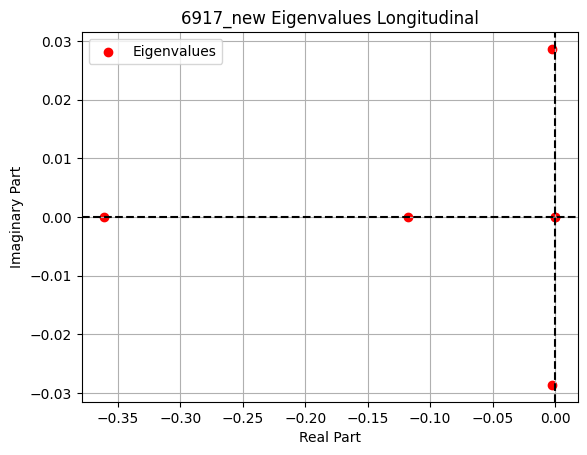

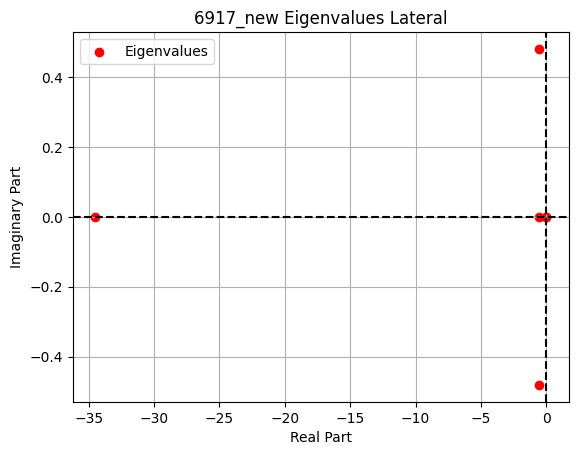

In [60]:
#Creating the EigenValuePlots
print(eigen_vals_long)
print(eigen_vals_lat)
#Eigenvals #needs to be dimensional eigenvalues for plot, shows more
long_real = [val.real for val in eigen_vals_long]
long_imag = [val.imag for val in eigen_vals_long]
lat_real =[val.real for val in eigen_vals_lat]
lat_imag = [val.imag for val in eigen_vals_lat]

#Longitudinal

Long_plot = plt.figure()
plt.scatter(long_real,long_imag,color='red',label='Eigenvalues')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title(f'{base_name} Eigenvalues Longitudinal')
plt.legend()
plt.grid(True)
Long_plot.savefig(f'{base_name}/Long_Eig_plot.png',dpi=200)
plt.show()

#Lateral

Lat_plot = plt.figure()
plt.scatter(lat_real,lat_imag,color='red',label='Eigenvalues')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title(f'{base_name} Eigenvalues Lateral')
plt.legend()
plt.grid(True)
Lat_plot.savefig(f'{base_name}/Lat_Eig_plot.png',dpi=200)
plt.show()


In [61]:
#Approximations of the Short period and Phuguoid mode of the aircraft, compare to true values

print('Long. Mode Approximation')

#Short Period Mode

A_sp = R_yy*(R_rhox+CL_alpha_hat)
B_sp = R_yy*(CL_alpha+CD_0)-Cm_qbar*(R_rhox + CL_alpha_hat)-Cm_alpha_hat*(R_rhox - CL_qbar)
C_sp = -Cm_qbar*(CL_alpha+CD_0)-Cm_alpha*(R_rhox-CL_qbar)

eigen_sp = (-B_sp + np.sqrt(B_sp**2-4*A_sp*C_sp))/(2*A_sp)
Damp_rate_sp = (V_0/Wing_MeanChord)*(B_sp/A_sp)
Frequency_sp = (V_0/Wing_MeanChord)*abs(np.sqrt(B_sp**2 -4*A_sp*C_sp)/A_sp)

print(f'\nShort Period Mode:\n')
print(f'Damping Rate: {Damp_rate_sp}')
if Damp_rate_sp < 0:
    print(f'Double Time: {np.log(2.00)/Damp_rate_sp}')
else:
    print(f'Damp Time 99%: {np.log(0.01)/(-Damp_rate_sp)}')
if Frequency_sp != 0:
    print(f'Damped Frequency[rad/s]: {Frequency_sp}')
    print(f'Period [s]: {2*np.pi/Frequency_sp}')

#Phugoid Mode

sigma_D = (g/V_0)*(CD_0/CL_0)
sigma_q = (g/V_0)*((Cm_qbar*(CL_0-CD_alpha))/(R_rhox*Cm_alpha+(CD_0+CL_alpha)*Cm_qbar))
R_ps = (R_rhox*Cm_alpha)/(R_rhox*Cm_alpha + Cm_qbar*(CD_0 + CL_alpha))
sigma_phi = -(g/V_0)*R_gx*R_ps*((R_rhox*Cm_qbar-R_yy*(CD_0+CL_alpha))/(R_rhox*Cm_alpha + (CD_0+CL_alpha)*Cm_qbar))

Damp_rate_phug = sigma_D + sigma_q + sigma_phi
Frequency_phug = np.sqrt(2*R_ps*(g/V_0)**2 - (sigma_D+sigma_q)**2) 

print(f'\nPhugoid Mode:\n')
print(f'Damping Rate: {Damp_rate_phug}')
if Damp_rate_phug < 0:
    print(f'Double Time: {np.log(2.00)/Damp_rate_phug}')
else:
    print(f'Damp Time 99%: {np.log(0.01)/(-Damp_rate_phug)}')
if Frequency_phug != 0:
    print(f'Damped Frequency[rad/s]: {Frequency_phug}')
    print(f'Period [s]: {2*np.pi/Frequency_phug}')

Long. Mode Approximation

Short Period Mode:

Damping Rate: 14.478947412637513
Damp Time 99%: 0.3180597356109331
Damped Frequency[rad/s]: 8.341655542206865
Period [s]: 0.7532300123624271

Phugoid Mode:

Damping Rate: 0.05273165486551232
Damp Time 99%: 87.33217642672496
Damped Frequency[rad/s]: 1.3299155612435667
Period [s]: 4.724499427094722


In [62]:
# Lateral Mode Approximations

print(f'Lateral Mode Approximation \n')

#Roll Mode

sigma_r = ((-V_0*Air_Density*Wing_Area*Wing_Span**2)/(4*I_xx))*Cl_pbar
print(f'\nDamping Rate Roll Mode: {sigma_r}')
if sigma_r > 0:
    print(f'Damping Time 99%: {np.log(0.01)/-sigma_r}')
else:
    print(f'Doubling Time: {np.log(2)/sigma_r}')

#spiral mode

sigma_spiral = (g/V_0)*((Cl_beta*Cn_rbar - Cl_rbar*Cn_beta)/(Cl_beta*Cn_pbar - Cl_pbar*Cn_beta))
print(f'\nDamping Rate Spiral Mode: {sigma_spiral}')
if sigma_spiral > 0:
    print(f'Damping Time 99%: {np.log(0.01)/-sigma_spiral}')
else:
    print(f'Doubling Time: {np.log(2)/-sigma_spiral}')

#Dutch Roll Approx
R_Ds = (Cl_beta*(R_gy*R_rhoy*R_zz-(R_rhoy-CY_rbar)*Cn_pbar) -CY_beta*Cl_rbar*Cn_pbar)/(R_rhoy*R_zz*Cl_pbar)
sigma_dr = (-V_0/Wing_Span)*(CY_beta/R_rhoy + Cn_rbar/R_zz - (Cl_rbar*Cn_pbar)/(Cl_pbar*R_zz) + (R_gy*(Cl_rbar*Cn_beta - Cl_beta*Cn_rbar))/(Cl_pbar*(Cn_beta+CY_beta*Cn_rbar/R_rhoy)) - R_xx*(R_Ds/Cl_pbar) )
Frequency_dr = (2*V_0/Wing_Span)*np.sqrt((1-CY_rbar/R_rhoy)*(Cn_beta/R_zz) + (CY_beta*Cn_rbar)/(R_rhoy*R_zz) + R_Ds -0.25*(CY_beta/R_rhoy + Cn_rbar/R_zz)**2 )


print(f'\nDamping Rate Dutch Roll Mode: {sigma_dr}')
if sigma_dr > 0:
    print(f'Damping Time 99%: {np.log(0.01)/-sigma_dr}')
else:
    print(f'Doubling Time: {np.log(2)/-sigma_dr}')
if Frequency_dr != 0:
    print(f'Damped Frequency[rad/s]: {Frequency_dr}')
    print(f'Period [s]: {2*np.pi/Frequency_dr}')
#print results
    
    

Lateral Mode Approximation 


Damping Rate Roll Mode: 86.05140971125256
Damping Time 99%: 0.05351649904912474

Damping Rate Spiral Mode: 2.069144185666328
Damping Time 99%: 2.2256400582857805

Damping Rate Dutch Roll Mode: 2.4709987945803427
Damping Time 99%: 1.8636877509162044
Damped Frequency[rad/s]: 0.66434459164456
Period [s]: 9.457720264758683


[ 0.        +0.j          0.        +0.j         -0.36100535+0.j
 -0.11773531+0.j         -0.00209302+0.02863327j -0.00209302-0.02863327j]
[  0.        +0.j           0.        +0.j
 -34.49509369+0.j          -0.54249838+0.48105721j
  -0.54249838-0.48105721j  -0.54701366+0.j        ]


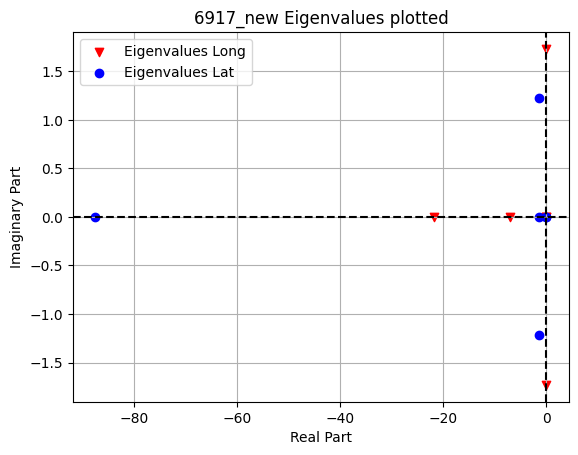

In [63]:
#Problem A14: Print the dimensional eigenvalues for the short period, phugoid, roll, spiral and dutch roll modes
#On a single graph
long_co = 2*V_0/Wing_MeanChord
lat_co = 2*V_0/Wing_Span
print(eigen_vals_long)
print(eigen_vals_lat)
eigen_vals_long_dim = np.asarray(eigen_vals_long)*long_co
eigen_vals_lat_dim = np.asarray(eigen_vals_lat)*lat_co

#Eigenvals #needs to be dimensional eigenvalues for plot, shows more
long_real = [val.real for val in eigen_vals_long_dim]
long_imag = [val.imag for val in eigen_vals_long_dim]
lat_real =[val.real for val in eigen_vals_lat_dim]
lat_imag = [val.imag for val in eigen_vals_lat_dim]



#Longitudinal

Eig_both = plt.figure()
plt.scatter(long_real,long_imag,color='red',label='Eigenvalues Long',marker='v')
plt.scatter(lat_real,lat_imag,color='blue',label='Eigenvalues Lat',marker='o')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title(f'{base_name} Eigenvalues plotted')
plt.legend()
plt.grid(True)
Eig_both.savefig(f'{base_name}/Eig_both_plot.png',dpi=200)
plt.show()


In [64]:
#A 15, getting the CAP factor for the aircraft

#Need the short period values
W_n_sp = np.sqrt((eigen_vals_long[2].real*eigen_vals_long[3].real))*(2*V_0/Wing_MeanChord)

print(f'Undamped Natural Frequency: {W_n_sp}')

#solve for the cap parameter

CAP = W_n_sp**2/(CL_alpha/CW)

print(f'CAP Value: {CAP}')



Undamped Natural Frequency: 12.454114440380506
CAP Value: 12.48568570246228


In [65]:
#A 16, compute the handling qualities for the baseline glider Category B flight phases

#Get all the needed values for each mode

#shortperiod
def shortperiod_B_handleval(eigenvalue1,eigenvalue2,vel,chord,CL_alpha,CW):
    #get the cap value
    wn_sp = np.sqrt((eigenvalue1*eigenvalue2))*(2*vel/chord)

    CAP = wn_sp**2/(CL_alpha/CW)
    print(f'Short Period CAP value: {round(CAP.real,4)}\n')

    #now we need the squiggle of the Short period
    num = -(eigenvalue1+eigenvalue2)
    denom = np.sqrt((eigenvalue1*eigenvalue2))

    squiggle = num/denom
    #give value dependent on CAP and Squiggle
    if 0.30 < squiggle < 2.00:
        print(f'Short Period Handling Level: 1\n')

    elif 0.20 < squiggle < 2.00:
        print(f'Short Period Handling Level: 2\n')
    elif 0.16 < squiggle:
        print(f'Short Period Handling Level: 3\n')
    else:
        print(f'Short Period Handling Level: 4, Iteration of Design Required\n')


#phugoid
def phugoid_B_handleval(eigenvalue1,eigenvalue2):
    sigma = -eigenvalue1.real

    #evaluate the squiggle
    num = -(eigenvalue1+eigenvalue2)
    denom = np.sqrt((eigenvalue1.real*eigenvalue2.real))
    squiggle = num/denom

    if sigma > 0:
        if sigma > 0.04:
            print(f'Phugoid Handling Level: 1\n')
        else:
            print(f'Phugoid Handling Level: 2\n')
    else:
        #check the doubling time
        double_time = -np.log(2.00)/sigma
        print(f'Divergent Mode: Doubling Time {round(double_time,2)}[sec]\n')
        if double_time > 55:
            print(f'Phugoid Handling Level: 3\n')
        else:
            print(f'Phugoid Handling Level: 4, Iteration of Design Required\n')

#Roll
def roll_B_handleval(eigenvalue):
    sigma = -eigenvalue.real

    HandlingQual = 1/sigma
    #give rating dependent on this value
    if HandlingQual > 0:
        if HandlingQual < 1.4:
            print(f'Roll Handling Level: 1\n')
        if 1.4 < HandlingQual < 3.0:
            print(f'Roll Handling Level: 2\n')
        if 3.0 < HandlingQual < 10.0:
            print(f'Roll Handling Level: 3\n')
        if HandlingQual > 10.0:
            print(f'Roll Handling Level: 4, Iteration of Design Required\n')
    else:
        print(f'Roll Handling Level: 4 Iteration of Design Required\n')

#dutch roll

def dutch_roll_B_handlevel(eigenvalue1,eigenvalue2,vel,span):
    #get the cap value
    wn_dutch = np.sqrt((eigenvalue1*eigenvalue2))*(2*vel/span)

    #now we need the squiggle of the Short period
    num = -(eigenvalue1+eigenvalue2)
    denom = np.sqrt((eigenvalue1.real*eigenvalue2.real))

    squiggle = num/denom

    cond_1 = squiggle
    cond_2 = squiggle*wn_dutch
    cond_3 = wn_dutch

    #Conditions for handling
    #first is it is divergent it is unacceptable
    if squiggle < 0:
        print(f'Ducth Roll Handling Level: 4, Iteration of Design Required\n')
    else:
        if cond_1 > 0.08 and cond_2 > 0.15 and cond_3 > 0.4:
            print(f'Dutch Roll Handling Level: 1\n')
        elif cond_1 > 0.02 and cond_2 > 0.05 and cond_3 > 0.4:
            print(f'Dutch Roll Handling Level: 2\n')
        elif cond_1 > 0.00 and cond_3 > 0.4:
            print(f'Dutch Roll Handling Level: 3\n')
        else:
            print(f'Dutch Roll Handling Level: 4, Iteration of Design Required\n')

#spiral

def spiral_B_handlevel(eigenvalue):
    sigma_spiral = -eigenvalue.real

    if sigma_spiral < 0:
        double_time = np.log(2.00)/-sigma_spiral
        if double_time > 20:
            print(f'Spiral Handling Level: 1\n')
        elif 20 > double_time > 12:
            print(f'Spiral Handling Level: 2\n')
        elif 12 > double_time > 4: 
            print(f'Spiral Handling Level: 3\n')
        else:
            print(f'Spiral Handling Level: 4, Interation of Design Required\n')
    else:
        print(f'Spiral Handling Level: 1\n')




In [66]:

#Give the Eigenvalues to each mode

#phugoid mode

Phugoid_eigenvalue_1 = eigen_vals_long[4]
Phugoid_eigenvalue_2 = eigen_vals_long[5]
phugoid_B_handleval(Phugoid_eigenvalue_1,Phugoid_eigenvalue_2)
#short period mode

Short_pred_eigenvalue_1 = eigen_vals_long[3]
Short_pred_eigenvalue_2 = eigen_vals_long[2]

shortperiod_B_handleval(Short_pred_eigenvalue_1,Short_pred_eigenvalue_2,vel=V_0,chord=Wing_MeanChord,CL_alpha=CL_alpha,CW=CW)

#Roll

Roll_eigenval = eigen_vals_lat[2]
roll_B_handleval(Roll_eigenval)

#spiral
Spiral_eigenval = eigen_vals_lat[5]
spiral_B_handlevel(Spiral_eigenval)

#dutchroll
dutch_eigenval_1 = eigen_vals_lat[3]
dutch_eigenval_2 = eigen_vals_lat[4]

dutch_roll_B_handlevel(dutch_eigenval_1,dutch_eigenval_2,vel=V_0,span=Wing_Span)


Phugoid Handling Level: 2

Short Period CAP value: 12.4857

Short Period Handling Level: 3

Roll Handling Level: 1

Spiral Handling Level: 1

Dutch Roll Handling Level: 1



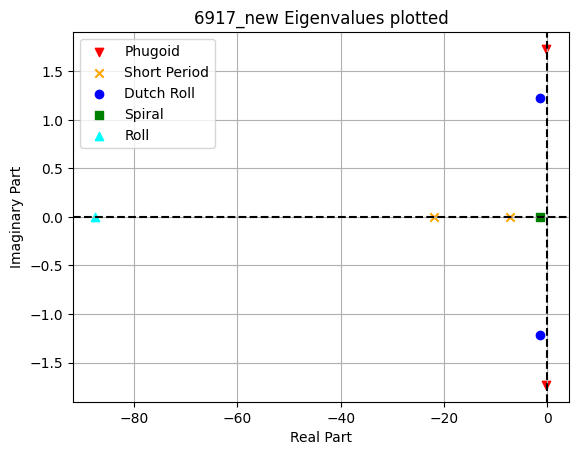

In [67]:
#Plot of all the eigenvalues with the modes labeled

#get the dimensional eigenvalues

#Phugoid

Phugoid_eigenvalue_1 = eigen_vals_long_dim[4]
Phugoid_eigenvalue_2 = eigen_vals_long_dim[5]

#short period mode

Short_pred_eigenvalue_1 = eigen_vals_long_dim[3]
Short_pred_eigenvalue_2 = eigen_vals_long_dim[2]

#Roll

Roll_eigenval = eigen_vals_lat_dim[2]

#spiral
Spiral_eigenval = eigen_vals_lat_dim[5]

#dutchroll
dutch_eigenval_1 = eigen_vals_lat_dim[4]
dutch_eigenval_2 = eigen_vals_lat_dim[3]

#Put evergything into one figure to see

Eigen_dim_plot = plt.figure()
plt.scatter(Phugoid_eigenvalue_1.real,Phugoid_eigenvalue_1.imag,color='red',label='Phugoid',marker='v')
plt.scatter(Phugoid_eigenvalue_2.real,Phugoid_eigenvalue_2.imag,color='red',marker='v')
plt.scatter(Short_pred_eigenvalue_2.real,Short_pred_eigenvalue_2.imag,color='orange',label='Short Period',marker='x')
plt.scatter(Short_pred_eigenvalue_1.real,Short_pred_eigenvalue_1.imag,color='orange',marker='x')
plt.scatter(dutch_eigenval_1.real,dutch_eigenval_1.imag,color='blue',label='Dutch Roll',marker='o')
plt.scatter(dutch_eigenval_2.real,dutch_eigenval_2.imag,color='blue',marker='o')
plt.scatter(Spiral_eigenval.real,Spiral_eigenval.imag,color='green',label='Spiral',marker='s')
plt.scatter(Roll_eigenval.real,Roll_eigenval.imag,color='cyan',label='Roll',marker='^')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title(f'{base_name} Eigenvalues plotted')
plt.legend()
plt.grid(True)
Eigen_dim_plot.savefig(f'{base_name}/Eig_Model_labeled.png',dpi=200)
plt.show()
